In [1]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, NHiTS, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import MAE, SMAPE, MQF2DistributionLoss, QuantileLoss

/Users/rohithreddynedhunuri/.pyenv/versions/3.10.13/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv('252115080293701.csv')
data

,Daily Date,well
0,1/1/01,2.06
1,1/2/01,2.04
2,1/3/01,2.02
3,1/4/01,2.01
4,1/5/01,2.00
...,...,...
8180,5/26/23,2.66
8181,5/27/23,2.68
8182,5/28/23,2.68
8183,5/29/23,2.67


In [3]:
data["Daily Date"] = pd.to_datetime(data["Daily Date"])
data
len(data)

/var/folders/x4/87cldz611xz7n8sb7wj3t62r0000gn/T/ipykernel_37536/143618580.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["Daily Date"] = pd.to_datetime(data["Daily Date"])


8185

In [4]:
data['series'] = (data['Daily Date'].dt.year - 2001)
data

,Daily Date,well,series
0,2001-01-01,2.06,0
1,2001-01-02,2.04,0
2,2001-01-03,2.02,0
3,2001-01-04,2.01,0
4,2001-01-05,2.00,0
...,...,...,...
8180,2023-05-26,2.66,22
8181,2023-05-27,2.68,22
8182,2023-05-28,2.68,22
8183,2023-05-29,2.67,22


In [5]:
data['time_idx'] = data.groupby('series').cumcount()
data

,Daily Date,well,series,time_idx
0,2001-01-01,2.06,0,0
1,2001-01-02,2.04,0,1
2,2001-01-03,2.02,0,2
3,2001-01-04,2.01,0,3
4,2001-01-05,2.00,0,4
...,...,...,...,...
8180,2023-05-26,2.66,22,145
8181,2023-05-27,2.68,22,146
8182,2023-05-28,2.68,22,147
8183,2023-05-29,2.67,22,148


In [6]:
data=data.fillna(data.mean())

In [7]:
data=data.filter(['Daily Date','well','series','time_idx'],axis=1)

In [8]:
data

,Daily Date,well,series,time_idx
0,2001-01-01,2.06,0,0
1,2001-01-02,2.04,0,1
2,2001-01-03,2.02,0,2
3,2001-01-04,2.01,0,3
4,2001-01-05,2.00,0,4
...,...,...,...,...
8180,2023-05-26,2.66,22,145
8181,2023-05-27,2.68,22,146
8182,2023-05-28,2.68,22,147
8183,2023-05-29,2.67,22,148


In [9]:
# create dataset and dataloaders
max_encoder_length = 5
max_prediction_length = 3

training_cutoff = data["time_idx"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="well",
    categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["series"],
    time_varying_unknown_reals=["well"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    allow_missing_timesteps=True,
)

validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

/Users/rohithreddynedhunuri/.pyenv/versions/3.10.13/lib/python3.10/site-packages/pytorch_forecasting/data/timeseries.py:1281: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 17 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__series': 0}, {'__group_id__series': 1}, {'__group_id__series': 2}, {'__group_id__series': 4}, {'__group_id__series': 5}, {'__group_id__series': 6}, {'__group_id__series': 8}, {'__group_id__series': 9}, {'__group_id__series': 10}, {'__group_id__series': 12}]
  warnings.warn(


In [10]:
# calculate baseline absolute error
baseline_predictions = Baseline().predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True)
SMAPE()(baseline_predictions.output, baseline_predictions.y)

/Users/rohithreddynedhunuri/.pyenv/versions/3.10.13/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/rohithreddynedhunuri/.pyenv/versions/3.10.13/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/rohithreddynedhunuri/.pyenv/versions/3.10.13/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider in

tensor(0.0075)

In [11]:
pl.seed_everything(42)
trainer = pl.Trainer(accelerator="cpu", gradient_clip_val=0.1)
net = NHiTS.from_dataset(
    training,
    learning_rate=3e-2,
    weight_decay=1e-2,
    loss=MQF2DistributionLoss(prediction_length=max_prediction_length),
    backcast_loss_ratio=0.0,
    hidden_size=64,
    optimizer="AdamW",
)

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/Users/rohithreddynedhunuri/.pyenv/versions/3.10.13/lib/python3.10/site-packages/lightning/pytorch/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
/Users/rohithreddynedhunuri/.pyenv/versions/3.10.13/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/rohithreddynedhunuri/.pyenv/versions/3.10.13/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
Finding best initial lr: 100%|███████████████████████████████████████████████████████████

suggested learning rate: 0.0027542287033381664


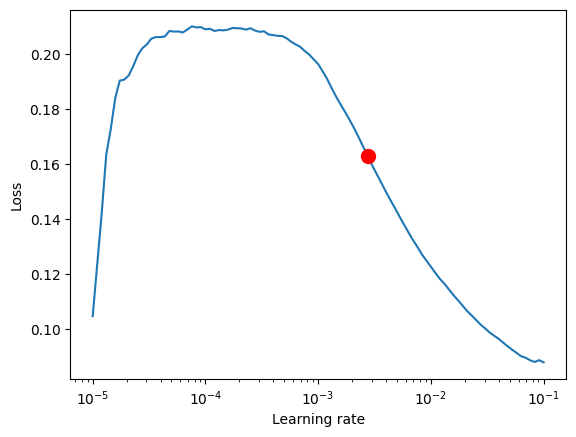

/var/folders/x4/87cldz611xz7n8sb7wj3t62r0000gn/T/ipykernel_37536/2821873794.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [12]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    net, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5, max_lr=1e-1
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [13]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=100, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=100,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=1.0,
    callbacks=[early_stop_callback],
    enable_checkpointing=True,
)


net = NHiTS.from_dataset(
    training,
    learning_rate=0.003,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    backcast_loss_ratio=0.0,
    hidden_size=64,
    optimizer="AdamW",
    loss=MQF2DistributionLoss(prediction_length=max_prediction_length),
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type                 | Params
---------------------------------------------------------
0 | loss            | MQF2DistributionLoss | 2.4 K 
1 | logging_metrics | ModuleList           | 0     
2 | embeddings      | MultiEmbedding       | 0     
3 | model           | NHiTS                | 15.7 K
---------------------------------------------------------
18.0 K    Trainable params
0         Non-trainable params
18.0 K    Total params
0.072     Total estimated model params size (MB)


Epoch 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:06<00:00,  9.30it/s, v_num=630, train_loss_step=0.0204]
Validation: |                                                                                                                                                                             | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:07<00:00,  8.35it/s, v_num=630, train_loss_step=0.023, val_loss=0.00579, train_loss_epoch=0.0436]
Validation: |                                                                                                                                                                             | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:07<00:00,  7.83it/s, v_num=630, train_loss_step=0.0191

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|███████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.34it/s, v_num=630, train_loss_step=0.0201, val_loss=0.00516, train_loss_epoch=0.0202]


In [14]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NHiTS.load_from_checkpoint(best_model_path)

In [15]:
predictions = best_model.predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True)
MAE()(predictions.output, predictions.y)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor(0.0044)

In [16]:
import torch
from torch.nn.functional import mse_loss
# Convert predictions and true values to PyTorch tensors if they are not already
y_pred = torch.tensor(predictions.output)
y_true = torch.tensor(predictions.y[0])

# Calculate MSE
mse_value = mse_loss(y_pred, y_true)

# Calculate RMSE
rmse_value = torch.sqrt(mse_value)

print("MSE:", mse_value.item())
print("RMSE:", rmse_value.item())
# Calculate the range of the true y values
y_true_range = torch.max(y_true) - torch.min(y_true)

# Calculate NRMSE
nrmse_value = rmse_value / y_true_range

print("NRMSE:", nrmse_value.item())

# Calculate the mean of the true y values
y_true_mean = torch.mean(y_true)

# Calculate the numerator and denominator for NSE
numerator = torch.sum((y_true - y_pred) ** 2)
denominator = torch.sum((y_true - y_true_mean) ** 2)
# Calculate NSE
nse_value = 1 - (numerator / denominator)

print("NSE:", nse_value.item())

MSE: 4.4028751290170476e-05
RMSE: 0.0066354162991046906


/var/folders/x4/87cldz611xz7n8sb7wj3t62r0000gn/T/ipykernel_37536/2060101331.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = torch.tensor(predictions.output)
/var/folders/x4/87cldz611xz7n8sb7wj3t62r0000gn/T/ipykernel_37536/2060101331.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_true = torch.tensor(predictions.y[0])
